In [60]:
#Basic Libs
import pandas as pd

import numpy as np


# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score,classification_report, precision_score, roc_curve, auc, precision_recall_fscore_support, precision_recall_curve


from sklearn.decomposition import PCA  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Vizualization
import matplotlib.pyplot as plt
import seaborn as sns

#warnings
import warnings

warnings.filterwarnings("ignore")

# Data Mining

In [61]:
data = pd.read_excel("/Users/lucazosso/Desktop/IE_Course/Term_2/Machine Learning II/Group Assignement/data/Songs_2024.xlsx", sheet_name= 1)
data1 = data.copy().dropna()
data1.shape



(2299, 19)

In [62]:
#dealing w/year
data1['track_age_2024'] =  data1['year'].map(lambda x: 2024-x)

#dealing w/genres
import re
#check number of unique sub_genres
genres_list = []
for genres_str in data1["artist_genres"]:
    cleaned_str = re.sub(r"[\[\]']", "", genres_str)
    genres = cleaned_str.split(';')
    for genre in genres:
        genres_list.append(genre.strip())

len(set(genres_list))

438

In [63]:
#dealing the genres
# Convert 'artist_genres' from string representation of a list to an actual list
# The genres are separated by ';', so we split on this character
data1['artist_genres'] = data1['artist_genres'].apply(lambda x: x.strip("[]").replace("'", "").split("; "))

# Define the genre mapping

mapping = {
    "pop": ['pop', 'pop punk', 'dance pop', 'europop', 'girl group', 'pop rap', 'bahamian pop', 'canadian pop', 'pop dance', 'post-teen pop', 'boy band', 'art pop', 'metropopolis', 'barbadian pop', 'viral pop', 'candy pop', 'australian pop', 'folk-pop', 'k-pop', 'bubblegum dance', 'pop dance'],
    "rock": ['permanent wave', 'alternative metal', 'modern rock', 'punk', 'rock', 'socal pop punk', 'alternative rock', 'dance rock', 'pop rock', 'celtic rock', 'irish rock', 'grunge', 'uk pop', 'neo mellow', 'piano rock', 'pov: indie', 'modern alternative rock', 'neon pop punk', 'garage rock', 'indie rock', 'canadian rock', 'british invasion', 'emo','neo-psychedelic','screamo','glam metal','beatlesque','madchester','supergroup'],
    "country": ['contemporary country', 'country', 'country dawn', 'country road'],
    "hip_hop_rap": ['detroit hip hop', 'hip hop', 'rap', 'dirty south rap', 'hip pop', 'east coast hip hop', 'hardcore hip hop', 'gangster rap', 'west coast rap', 'st louis rap', 'trap', 'southern hip hop', 'atl hip hop', 'melodic rap', 'miami hip hop', 'chicago rap', 'canadian hip hop', 'old school atlanta hip hop', 'queens hip hop', 'crunk', 'conscious hip hop', 'trap queen', 'south carolina hip hop', 'new orleans rap', 'G Funk','brooklyn drill','hyphy','atlanta bass'],
    "rnb_soul": ['contemporary r&b', 'r&b', 'urban contemporary', 'british soul', 'neo soul', 'pop soul', 'canadian contemporary r&b','soul','pluggnb'],
    "house_and_pop_fusion" : ['disco house', 'filter house', 'bouncy house', 'electro house', 'slap house', 'tropical house', 'pop dance', 'house', 'progressive house', 'indietronica', 'progressive electro house', 'uk garage', 'big room', 'complextro'],
    "underground_electronic" : ['electro', 'big beat', 'downtempo', 'melbourne bounce international', 'electro trash', 'grave wave', 'dark clubbing', 'ukg revival', 'hardcore techno', 'grime', 'instrumental grime', 'dancefloor dnb', 'trance', 'speed garage','new wave','bounce','handsup','chicago hardcore','rave','german techno','hamburg electronic','happy hardcore', 'industrial','techno'],
    "metal": ['nu metal', 'post-grunge', 'rap metal', 'funk metal', 'industrial metal'],
    "jazz": ['jazz', 'smooth jazz', 'bebop', 'swing', 'fusion jazz', 'stomp and holler'],
    "classical": ['classical', 'baroque', 'romantic', 'symphony', 'opera'],
    "reggae": ['reggae', 'dancehall', 'reggae fusion', 'dub', 'roots reggae','moombahton'],
    "latin": ['latin', 'reggaeton', 'latin pop', 'salsa', 'bachata', 'merengue', 'tango', 'cumbia', 'trap latino', 'urbano latino', 'mexican pop', 'colombian pop', 'mambo chileno','urbano chileno', 'tropical'],
    "singer-songwriter": ['singer-songwriter pop', 'singer-songwriter'],
    "folk":['folk','classic schlager', 'oktoberfest', 'schlager', 'celtic','middle earth','sertanejo','sertanejo universitario'],
    "talent show": ['talent show']
}

# Flatten the mapping for easier access
flat_mapping = {}
for main_genre, subgenres in mapping.items():
    for subgenre in subgenres:
        flat_mapping[subgenre] = main_genre

# Function to categorize genres
def categorize_genres(genres_list, mapping):
    genre_counts = {}
    for genre in genres_list:
        for subgenre, main_genre in mapping.items():
            if subgenre in genre:
                genre_counts[main_genre] = genre_counts.get(main_genre, 0) + 1
    if genre_counts:
        # Return the most frequent main genre, if tie, sorted order decides
        return max(genre_counts, key=genre_counts.get)
    else:
        return "other"  # or "other" if you prefer to label unmatched genres as "other"

# Apply the categorization function
data1['dominant_genre'] = data1['artist_genres'].apply(lambda x: categorize_genres(x, flat_mapping))


In [64]:
#dealing with keys
# Define the mapping dictionary for music keys
key_mapping = {0.: 'C',1.: 'C#',2.: 'D',3: 'D#',4.: 'E',5.: 'F',6.: 'F#',7.: 'G',8.: 'G#',9.: 'A',10.: 'A#',11.: 'B'}

data1['key'] = data1['key'].map(key_mapping)

#dealing w/mode
tone = {0 : 'min', 1: 'Maj'}
data1['mode'] = data1['mode'].map(tone)

#create tonality
data1['tonality'] = data1['key'] + data1['mode']


# Bining Target Variable


In [65]:
def categorize_song4(popularity):
    if popularity < 60:
        return 0 #'Niche'
    elif 60 <= popularity < 80:
        return 1 #'Moderate'
    elif 80 <= popularity < 90:
        return 2 #'Popular'
    else:  # This covers popularity >= 90
        return 3 #'Hit'


def categorize_song3(popularity):
    if popularity < 60:
        return 0 #Niche
    elif 60 <= popularity < 85:
        return 1 #Moderate
    else:  # This covers popularity >= 90
        return 2 #popular

def categorize_song_binary(popularity):
    if popularity < 60:
        return 0 #'Niche'
    else:
        return 1

def categorize_song_weighted_age(popularity, age, base_threshold=65, age_adjustment_rate=5, adjustment_amount=1):
    """
    Categorize song based on popularity and age.
    
    Parameters:
    - popularity: The popularity of the track.
    - age: The age of the track.
    - base_threshold: The base threshold for considering a song popular.
    - age_adjustment_rate: The number of years required for an adjustment.
    - adjustment_amount: The amount to adjust the threshold by for each age_adjustment_rate years.
    
    Returns:
    - 0 if the song is below the adjusted threshold (less popular).
    - 1 if the song is above the adjusted threshold (more popular).
    """
    # Adjust the threshold based on the age of the track
    adjusted_threshold = base_threshold - (age // age_adjustment_rate) * adjustment_amount
    
    # Categorize the song based on the adjusted threshold
    if popularity < adjusted_threshold:
        return 0  # 'Others'
    else:
        return 1  # 'Popular'

def categorize_song_with_age_and_artist(popularity, age, artist_popularity, 
                                        base_threshold=65, age_adjustment_rate=5, 
                                        adjustment_amount=1, artist_weight=0.1):
    """
    Categorize song based on popularity, age, and artist popularity.
    
    Parameters:
    - popularity: The popularity of the track.
    - age: The age of the track.
    - artist_popularity: The popularity of the artist.
    - base_threshold: The base threshold for considering a song popular.
    - age_adjustment_rate: The number of years required for an adjustment.
    - adjustment_amount: The amount to adjust the threshold by for each age_adjustment_rate years.
    - artist_weight: The weight given to artist popularity in the final score.
    
    Returns:
    - 0 if the song is below the adjusted threshold (less popular).
    - 1 if the song is above the adjusted threshold (more popular).
    """
    # Calculate a combined popularity score with a weighted average
    combined_popularity = (popularity * (1 - artist_weight)) + (artist_popularity * artist_weight)
    
    # Adjust the threshold based on the age of the track
    adjusted_threshold = base_threshold - (age // age_adjustment_rate) * adjustment_amount
    
    # Categorize the song based on the adjusted threshold
    if combined_popularity < adjusted_threshold:
        return 0  # 'Niche'
    else:
        return 1  # 'Popular'
   
######### BASIC BINING ALGORITHM ###########   
#switch function to different cat
#data1['song_popularity_labels'] = data1.apply(lambda x: categorize_song_binary(x['track_popularity']), axis=1)
# Apply the new function to the dataset

######### Weighted Track AGE BINING ALGORITHM ###########  

#data1['song_popularity_labels'] = data1.apply(lambda x: categorize_song_weighted_age(x['track_popularity'], x['track_age_2024']), axis=1)

######### Weighted Track AGE + weighted Artist Popularity BINING ALGORITHM ########### 
# Apply the new function to the dataset
data1['song_popularity_labels'] = data1.apply(lambda x: categorize_song_with_age_and_artist(x['track_popularity'], x['track_age_2024'], x['artist_popularity']), axis=1)




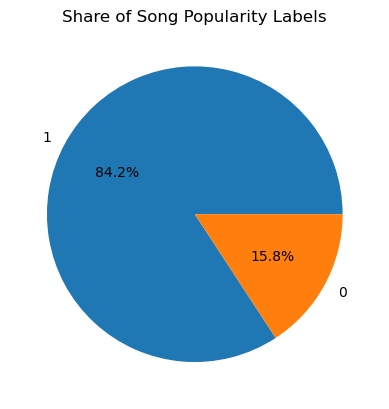

In [66]:
import matplotlib.pyplot as plt

# Count the occurrences of each label
label_counts = data1['song_popularity_labels'].value_counts()

# Create a pie chart
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')

# Add a title
plt.title('Share of Song Popularity Labels')

# Display the chart
plt.show()


In [67]:
print(data.shape)
print(data1.shape)
print(data1.columns)

(2300, 19)
(2299, 23)
Index(['year', 'track_name', 'track_popularity', 'album', 'artist_name',
       'artist_genres', 'artist_popularity', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'track_age_2024',
       'dominant_genre', 'tonality', 'song_popularity_labels'],
      dtype='object')


In [68]:
data1.dtypes

year                        int64
track_name                 object
track_popularity            int64
album                      object
artist_name                object
artist_genres              object
artist_popularity           int64
danceability              float64
energy                    float64
key                        object
loudness                  float64
mode                       object
speechiness               float64
acousticness              float64
instrumentalness          float64
liveness                  float64
valence                   float64
tempo                     float64
duration_ms               float64
track_age_2024              int64
dominant_genre             object
tonality                   object
song_popularity_labels      int64
dtype: object

# One Hot Encoding

In [69]:
#dummified dominant_genre
# Perform one-hot encoding
data1 = pd.get_dummies(data1, columns=['dominant_genre'], prefix_sep="_",prefix="genre",dtype=int)
# Drop a specific column
data1 = data1.drop('genre_talent show', axis=1)
print(sum(data1.columns.str.contains("genre_") == True))

#dummified tonality
data1 = pd.get_dummies(data1, columns=['tonality'],prefix_sep="_",prefix="tone",drop_first=True, dtype=int)
print(sum(data1.columns.str.contains('tone_')))

14
23


# Dimension Reduction (PCA) for Audio Features

In [70]:
audio_features = ['danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms']

pca_data = data1[audio_features]

ss = StandardScaler().fit(pca_data)
X_std = ss.transform(pca_data)

sklearn_pca = PCA()
Y_sklearn = sklearn_pca.fit_transform(X_std)

VARIANCE_TO_KEEP = 0.75
keep_recommend = [sklearn_pca.explained_variance_ratio_[:y].sum()>VARIANCE_TO_KEEP for y in range(1,sklearn_pca.n_components_+1)].count(False)
print("Number of components to keep to retain %s%% of the variance:" % (100*VARIANCE_TO_KEEP), keep_recommend, "out of the original", sklearn_pca.n_components_)
retained_components_number = keep_recommend

sklearn_pca_final = PCA(n_components=retained_components_number)
Y_sklearn_final = sklearn_pca_final.fit_transform(X_std)

data1_PCA = pd.concat([data1, pd.DataFrame(Y_sklearn_final[:, :5], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])], axis=1)
data1_PCA.rename(columns={'PC1': 'PC1_Energetic_Dynamic', 'PC2': 'PC2_Speech_Tempo', 'PC3': 'PC3_Acoustic_Speech', 'PC4': 'PC4_Duration_Mood ', 'PC5': 'PC5_Acoustic_Liveness'}, inplace=True)
data1_PCA.head()

Number of components to keep to retain 75.0% of the variance: 5 out of the original 10


,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,...,tone_Fmin,tone_G#Maj,tone_G#min,tone_GMaj,tone_Gmin,PC1_Energetic_Dynamic,PC2_Speech_Tempo,PC3_Acoustic_Speech,PC4_Duration_Mood,PC5_Acoustic_Liveness
0,2000.0,Yellow,91.0,Parachutes,Coldplay,"[permanent wave, pop]",86.0,0.429,0.661,B,...,0.0,0.0,0.0,0.0,0.0,0.697489,2.681419,-0.475313,0.575820,0.265080
1,2000.0,All The Small Things,84.0,Enema Of The State,blink-182,"[alternative metal, modern rock, pop punk, pun...",75.0,0.434,0.897,C,...,0.0,0.0,0.0,0.0,0.0,-1.863289,2.037136,-0.917177,0.337012,-0.962087
2,2000.0,Breathe,69.0,Breathe,Faith Hill,"[contemporary country, country, country dawn, ...",61.0,0.529,0.496,G,...,0.0,0.0,0.0,1.0,0.0,1.955014,1.289486,-0.361391,-0.056666,0.118168
3,2000.0,In the End,88.0,Hybrid Theory (Bonus Edition),Linkin Park,"[alternative metal, nu metal, post-grunge, rap...",83.0,0.556,0.864,D#,...,0.0,0.0,0.0,0.0,0.0,-0.464720,0.915760,0.304314,-0.611131,0.001659
4,2000.0,Bye Bye Bye,74.0,No Strings Attached,*NSYNC,"[boy band, dance pop, pop]",65.0,0.610,0.926,G#,...,0.0,0.0,1.0,0.0,0.0,-1.901801,0.609784,0.664915,1.312768,-0.747559


In [71]:
data1_PCA = data1_PCA.rename_axis("song_id")
data1_PCA.head()

,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,...,tone_Fmin,tone_G#Maj,tone_G#min,tone_GMaj,tone_Gmin,PC1_Energetic_Dynamic,PC2_Speech_Tempo,PC3_Acoustic_Speech,PC4_Duration_Mood,PC5_Acoustic_Liveness
song_id,,,,,,,,,,,,,,,,,,,,,
0,2000.0,Yellow,91.0,Parachutes,Coldplay,"[permanent wave, pop]",86.0,0.429,0.661,B,...,0.0,0.0,0.0,0.0,0.0,0.697489,2.681419,-0.475313,0.575820,0.265080
1,2000.0,All The Small Things,84.0,Enema Of The State,blink-182,"[alternative metal, modern rock, pop punk, pun...",75.0,0.434,0.897,C,...,0.0,0.0,0.0,0.0,0.0,-1.863289,2.037136,-0.917177,0.337012,-0.962087
2,2000.0,Breathe,69.0,Breathe,Faith Hill,"[contemporary country, country, country dawn, ...",61.0,0.529,0.496,G,...,0.0,0.0,0.0,1.0,0.0,1.955014,1.289486,-0.361391,-0.056666,0.118168
3,2000.0,In the End,88.0,Hybrid Theory (Bonus Edition),Linkin Park,"[alternative metal, nu metal, post-grunge, rap...",83.0,0.556,0.864,D#,...,0.0,0.0,0.0,0.0,0.0,-0.464720,0.915760,0.304314,-0.611131,0.001659
4,2000.0,Bye Bye Bye,74.0,No Strings Attached,*NSYNC,"[boy band, dance pop, pop]",65.0,0.610,0.926,G#,...,0.0,0.0,1.0,0.0,0.0,-1.901801,0.609784,0.664915,1.312768,-0.747559


In [72]:
#rename index
data1_PCA = data1_PCA.rename_axis("song_id")
data1_PCA.columns

Index(['year', 'track_name', 'track_popularity', 'album', 'artist_name',
       'artist_genres', 'artist_popularity', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'track_age_2024',
       'song_popularity_labels', 'genre_country', 'genre_folk',
       'genre_hip_hop_rap', 'genre_house_and_pop_fusion', 'genre_jazz',
       'genre_latin', 'genre_metal', 'genre_other', 'genre_pop',
       'genre_reggae', 'genre_rnb_soul', 'genre_rock',
       'genre_singer-songwriter', 'genre_underground_electronic', 'tone_A#min',
       'tone_AMaj', 'tone_Amin', 'tone_BMaj', 'tone_Bmin', 'tone_C#Maj',
       'tone_C#min', 'tone_CMaj', 'tone_Cmin', 'tone_D#Maj', 'tone_D#min',
       'tone_DMaj', 'tone_Dmin', 'tone_EMaj', 'tone_Emin', 'tone_F#Maj',
       'tone_F#min', 'tone_FMaj', 'tone_Fmin', 'tone_G#Maj', 'tone_G#min',
       'tone_GMaj', 'tone_Gmin', 'PC1_Energetic_Dynamic', 'PC2_Spee

In [73]:
print(data1_PCA.dtypes)

year                     float64
track_name                object
track_popularity         float64
album                     object
artist_name               object
                          ...   
PC1_Energetic_Dynamic    float64
PC2_Speech_Tempo         float64
PC3_Acoustic_Speech      float64
PC4_Duration_Mood        float64
PC5_Acoustic_Liveness    float64
Length: 63, dtype: object


In [74]:
# download data in csv
data1_PCA.to_csv("/Users/lucazosso/Desktop/IE_Course/Term_2/Machine Learning II/Group Assignement/data/modeling/data_cleaned_final_PCA.csv")

# Starting Checking the Model

In [75]:
tlabel3 = "/Users/lucazosso/Desktop/IE_Course/Term_2/Machine Learning II/Group Assignement/data/data_cleaned_3lab.xlsx"
tlabel3_PCA = "/Users/lucazosso/Desktop/IE_Course/Term_2/Machine Learning II/Group Assignement/data/modeling/data_cleaned_final_PCA.csv"

### Data Loading

In [76]:
data = pd.read_csv(tlabel3_PCA,index_col="song_id")


cols_to_drop = ['year', 'track_name', 'track_popularity', 'album', 'artist_name',
       'artist_genres', 'mode', 'key', 'artist_popularity', 'track_age_2024']
data = data.drop(columns = cols_to_drop)
data.columns

Index(['artist_popularity', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'track_age_2024',
       'song_popularity_labels', 'genre_country', 'genre_folk',
       'genre_hip_hop_rap', 'genre_house_and_pop_fusion', 'genre_jazz',
       'genre_latin', 'genre_metal', 'genre_other', 'genre_pop',
       'genre_reggae', 'genre_rnb_soul', 'genre_rock',
       'genre_singer-songwriter', 'genre_underground_electronic', 'tone_A#min',
       'tone_AMaj', 'tone_Amin', 'tone_BMaj', 'tone_Bmin', 'tone_C#Maj',
       'tone_C#min', 'tone_CMaj', 'tone_Cmin', 'tone_D#Maj', 'tone_D#min',
       'tone_DMaj', 'tone_Dmin', 'tone_EMaj', 'tone_Emin', 'tone_F#Maj',
       'tone_F#min', 'tone_FMaj', 'tone_Fmin', 'tone_G#Maj', 'tone_G#min',
       'tone_GMaj', 'tone_Gmin', 'PC1_Energetic_Dynamic', 'PC2_Speech_Tempo',
       'PC3_Acoustic_Speech', 'PC4_Duration_Mood ', 'PC5_Acoustic_Liveness'],
      dtype='obj

In [77]:
df = data.copy()
#drop 2 null rows ==> TO BE CHECKED
df.drop(index=[2299,447], inplace=True)

rand_seed = 477
acc="accuracy" # our metric for Grid Searching

PCA_Data = df.drop(columns=audio_features)
Data = df.loc[:, ~df.columns.str.contains('PC_')]



In [78]:
def split_df(dataframe, seed=None ,percentage=0.8):
    
    X = dataframe.loc[:, dataframe.columns != 'song_popularity_labels']
    y = dataframe['song_popularity_labels']

    return train_test_split(X, y, test_size=1-percentage, random_state=seed, stratify=y) # note the stratify parameter

# MODELING STARTS HERE

### Train Test Split

In [79]:
# train_test_split
X_train, X_test, Y_train, Y_test = split_df(Data, seed=rand_seed, percentage=0.7)
print("Number of explanatories: ", len(Data.columns)-1)

Number of explanatories:  54


#### Functions for Model Performances

In [80]:
# Function to print Confusion Matrix and Classification Report
# df_cm, df_perf = model_perf(titanic_tree_pruned, Y_test, predictions, "Classification Tree", df_cm, df_perf, plot = True)


def model_perf(model, Y_test, Y_predict, algorithm, df_cm, df_perf, ax=None, plot = True):
    # confusion_matrix
    conf_mat = confusion_matrix(Y_test, Y_predict)
    
    # get accuracy of model
    acc_score = accuracy_score(Y_test, Y_predict)
    print(f"Accuracy of {algorithm} for Test data is {acc_score*100}\n")

    # get F1-score of model
    f1score = f1_score(Y_test, Y_predict) 
    print(f"F1-score of {algorithm} for Test data is {f1score*100}\n")
    
    # get the classification report
    class_report = classification_report(Y_test, Y_predict)
    print(f"Classification report for {algorithm} is: \n {class_report}")
    
    # AUC Calculations - false positive rates, true positive rates and thresholds
    fpr, tpr, thresholds = roc_curve(Y_test, Y_predict, pos_label=1)
    
    #area_under_curve
    roc_auc = round(auc(fpr, tpr)*100,2)
    print(f"AUC for {algorithm}: {roc_auc}\n")
    
    #Train Accuracy score
    train_acc = round(model.score(X_train,Y_train) * 100,2)

    #Test Accuracy score
    test_acc = round(model.score(X_test,Y_test) * 100,2)

    precision,recall,fscore,support = precision_recall_fscore_support(Y_test,Y_predict)

    #Appending into the dataframe
    newrow_perf= pd.DataFrame({'Model' : [algorithm],'Train Accuracy' : [train_acc],'Test Accuracy' : [test_acc],
                          'F1-Score' : [fscore[1]],'Recall' : [recall[1]], 'Precision' : [precision[1]], 'AUC' : [roc_auc]})
    
    df_perf = pd.concat([df_perf, newrow_perf], ignore_index=True)

    
    newrow_cm= pd.DataFrame({"Model" : [algorithm], "True Positives" : [conf_mat[1][1]], "True Negatives" : [conf_mat[0][0]],
                             "False Positives" : [conf_mat[0][1]], "False Negatives" : [conf_mat[1][0]]})
                            
    df_cm = pd.concat([df_cm, newrow_cm], ignore_index=True, sort=False)

##########################################--PLOT---###########################################
    if plot:
        def conf_plot1(ax = None):
            if ax is None:
                fig, ax = plt.subplots()
            # For label annotations in confusion_matrix
            label_names = ['True N','False N','False P','True P']
            label_counts = ['{0:0.0f}'.format(value) for value in conf_mat.flatten()]
            labels = [f'{v1}\n{v2}' for v1, v2 in zip(label_names,label_counts)]
            labels = np.asarray(labels).reshape(2,2)

            # Draw heatmap using confusion matrix
            sns.heatmap(conf_mat, annot=labels, fmt='')
            ax.set_xlabel('Actual Values')
            ax.set_ylabel('Predicted Values')
            #ax.show()

        #Line plot for ROC curve using fpr and tpr value
        def roc_plot2(ax = None):
            if ax is None:
                fig, ax = plt.subplots()
            ax.plot(fpr, tpr, color='red', label = 'AUC = %0.3f' % roc_auc)  
            ax.set_title('Receiver Operating Characteristic (ROC)')    
            ax.legend(loc = 'lower right')
            ax.plot([0, 1], [0, 1],linestyle='--') #Intersection line
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_xlim([0,1])
            ax.set_ylim([0,1])
            ax.set_xticks([i for i in np.arange(0,1.1,0.1)])
            ax.set_yticks([i for i in np.arange(0,1.1,0.1)])
        
        prec, rec, thres = precision_recall_curve(Y_test, Y_predict)
        prec, rec, thres = prec.tolist(), rec.tolist(), thres.tolist()
        prec.pop()
        rec.pop()
            
        def rec_plot3(ax = None):
            if ax is None:
                fig, ax = plt.subplots()
            #Plot Precision-Recall curve
            fig, axis = (None, ax) if ax else plt.subplots()
            axis_twin = axis.twinx()

            #Threshold vs Precision
            sns.lineplot(x = thres, y = prec, label='Precision', ax=axis)
            axis.set_xlabel('Threshold')
            axis.set_ylabel('Precision')
            axis.legend(loc='lower left')

            #Threshold vs Recall
            sns.lineplot(x = thres, y = rec, color='limegreen', label='Recall', ax=axis_twin)
            axis_twin.set_ylabel('Recall')
            axis_twin.set_ylim(0, 1)
            axis_twin.legend(bbox_to_anchor=(0.32, 0.20),loc='lower right')

            axis.set_xlim(0, 1)
            axis.set_ylim(0, 1)
            axis.set_title('Precision Vs Recall')
        
                    
        fig = plt.figure(figsize = (15,4))
        ax1 = fig.add_subplot(1,3,1)
        conf_plot1(ax1)
        ax2 = fig.add_subplot(1,3,2)
        roc_plot2(ax2)
        axis = fig.add_subplot(1,3,3)
        rec_plot3(axis)
    
    
    return df_cm, df_perf

## Logistics Regressions

Wo/PCA

In [81]:

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, Y_train)
predictions_log = log_reg.predict(X_test)
class_report = classification_report(Y_test, predictions_log)
acclog = accuracy_score(Y_test, predictions_log)
f1_Log = f1_score(Y_test,predictions_log, average='weighted')
precision_Log = precision_score(Y_test, predictions_log, average='weighted')
recall_Log = recall_score(Y_test, predictions_log, average='weighted')

#print(class_report)

Accuracy of Log w/o PCA for Test data is 85.65217391304348

F1-score of Log w/o PCA for Test data is 92.08633093525181

Classification report for Log w/o PCA is: 
               precision    recall  f1-score   support

         0.0       0.75      0.14      0.23       109
         1.0       0.86      0.99      0.92       581

    accuracy                           0.86       690
   macro avg       0.80      0.56      0.58       690
weighted avg       0.84      0.86      0.81       690

AUC for Log w/o PCA: 56.45



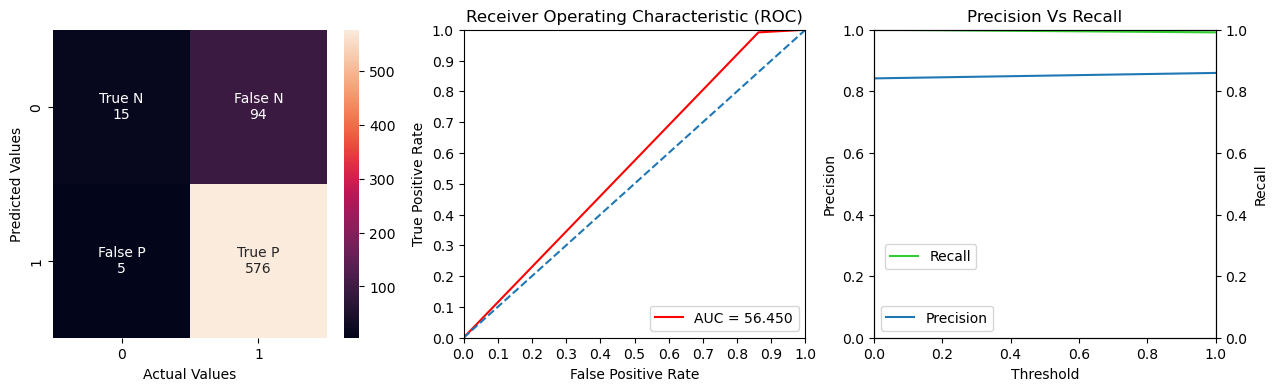

In [82]:
# Dataframe to store Model Performance Results
perf_cols = ['Model','Train Accuracy','Test Accuracy','F1-Score','Recall','Precision', 'AUC']
df_perf = pd.DataFrame(columns = perf_cols)

# DataFrame for Confusion matrix
conf_mat_cols = ['Model','False Negatives','False Positives','True Negatives','True Positives']
df_cm = pd.DataFrame(columns = conf_mat_cols)

# DataFrame for cross validation scores
cv_cols = ['Model','Best_Cross_Val_Score']
df_cv = pd.DataFrame(columns = cv_cols)

#Draw Model Performace, Confusion Matrix and Classification Report
#logistic
df_cm, df_perf = model_perf(log_reg, Y_test, predictions_log, "Log w/o PCA", df_cm, df_perf, plot = True)

W/PCA

In [83]:
log_reg_PCA = LogisticRegression()
log_reg_PCA.fit(X_train, Y_train)
predictions_log_PCA = log_reg_PCA.predict(X_test)
class_report_PCA_Logit = classification_report(Y_test, predictions_log_PCA)

f1_Log_PCA = f1_score(Y_test,predictions_log_PCA, average='weighted')
precision_Log_PCA = precision_score(Y_test, predictions_log_PCA, average='weighted')
recall_Log_PCA = recall_score(Y_test, predictions_log_PCA, average='weighted')


#print(class_report_PCA_Logit)

Accuracy of Log PCA for Test data is 85.65217391304348

F1-score of Log PCA for Test data is 92.08633093525181

Classification report for Log PCA is: 
               precision    recall  f1-score   support

         0.0       0.75      0.14      0.23       109
         1.0       0.86      0.99      0.92       581

    accuracy                           0.86       690
   macro avg       0.80      0.56      0.58       690
weighted avg       0.84      0.86      0.81       690

AUC for Log PCA: 56.45



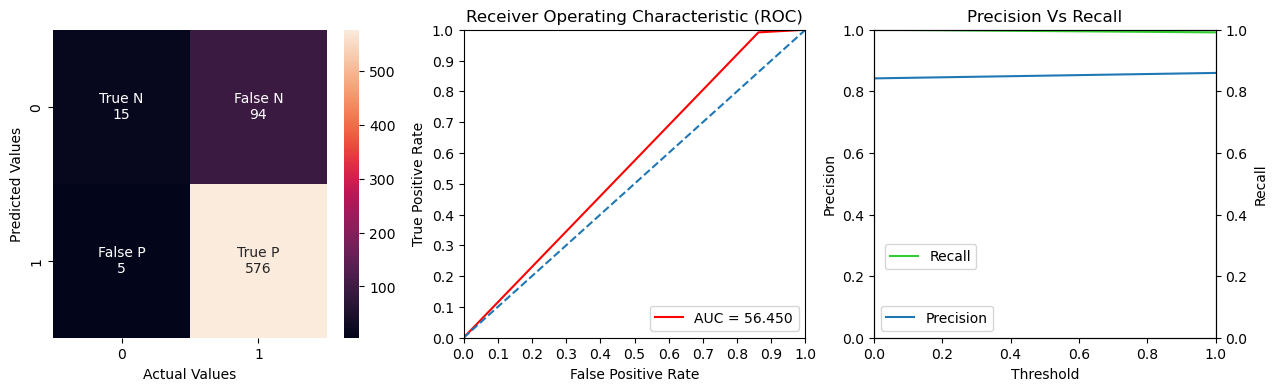

In [84]:
#logistic w/PCA
df_cm, df_perf = model_perf(log_reg_PCA, Y_test, predictions_log_PCA, "Log PCA", df_cm, df_perf, plot = True)

## Decision Tree

In [85]:

# train_test_split
#X_train, X_test, Y_train, Y_test = split_df(PCA_Data, seed=rand_seed, percentage=0.7)
#print("Number of explanatories: ", len(Data.columns)-1)

decision_tree = DecisionTreeClassifier() # by default Gini index, no random replication
decision_tree.fit(X_train, Y_train)
predictions_DT = decision_tree.predict(X_test)
accDT=accuracy_score(Y_test, predictions_DT)
print("Accuracy test set Decision Trees (not pruned) = {0:.2%}".format(accDT))

f1_Tree = f1_score(Y_test,predictions_DT, average='weighted')
precision_Tree = precision_score(Y_test, predictions_DT, average='weighted')
recall_Tree = recall_score(Y_test, predictions_DT, average='weighted')

class_report_Decision_Tree = classification_report(Y_test, predictions_DT)
#print(class_report_Decision_Tree)


Accuracy test set Decision Trees (not pruned) = 80.29%


Accuracy of DT PCA for Test data is 80.28985507246377

F1-score of DT PCA for Test data is 88.17391304347825

Classification report for DT PCA is: 
               precision    recall  f1-score   support

         0.0       0.39      0.43      0.41       109
         1.0       0.89      0.87      0.88       581

    accuracy                           0.80       690
   macro avg       0.64      0.65      0.65       690
weighted avg       0.81      0.80      0.81       690

AUC for DT PCA: 65.19



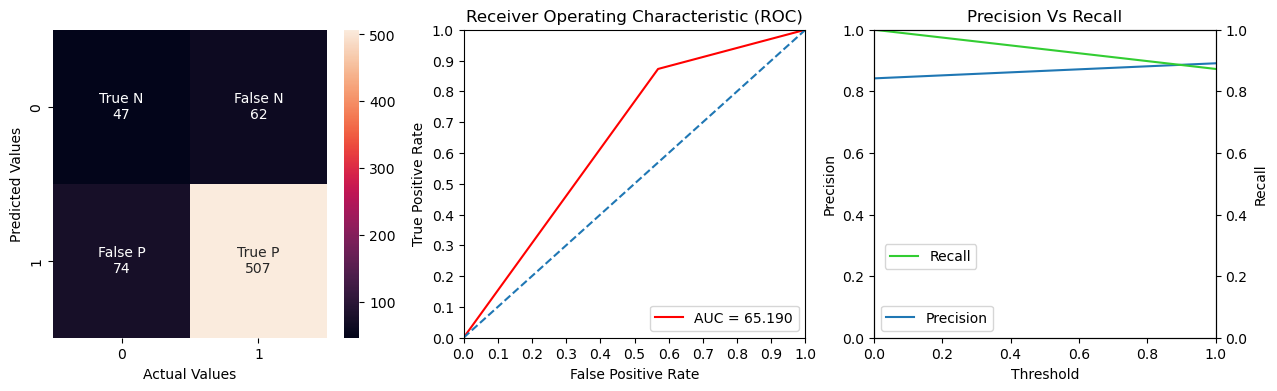

In [86]:
#Decision Tree PCA
df_cm, df_perf = model_perf(decision_tree, Y_test, predictions_DT, "DT PCA", df_cm, df_perf, plot = True)

In [87]:

#with GRID SEARCH

# train_test_split
#X_train, X_test, Y_train, Y_test = split_df(PCA_Data, seed=rand_seed, percentage=0.7)
#print("Number of explanatories: ", len(Data.columns)-1)

param_grid = {
    'max_depth': range(1,16)
    } 

tree_grid = GridSearchCV(decision_tree, param_grid, scoring=acc, cv=5 , n_jobs=1, verbose=1)
tree_grid.fit(X_train,Y_train)
print("Best param: ", tree_grid.best_params_)
tree_pruned = DecisionTreeClassifier(max_depth=tree_grid.best_params_["max_depth"], criterion="entropy")
tree_pruned.fit(X_train, Y_train)
predictions_DT_G = tree_pruned.predict(X_test)
accDTGrid=accuracy_score(Y_test, predictions_DT_G)
print("Accuracy of Test set (pruned) = {0:.2%}".format(accDTGrid))

f1_TreeGrid = f1_score(Y_test,predictions_DT_G, average='weighted')
precision_TreeGrid = precision_score(Y_test, predictions_DT_G, average='weighted')
recall_TreeGrid = recall_score(Y_test, predictions_DT_G, average='weighted')

class_report_Decision_Tree_Grid = classification_report(Y_test, predictions_DT_G)
#print(class_report_Decision_Tree_Grid)


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best param:  {'max_depth': 2}
Accuracy of Test set (pruned) = 86.09%


Accuracy of DTGrid PCA for Test data is 86.08695652173914

F1-score of DTGrid PCA for Test data is 92.34449760765551

Classification report for DTGrid PCA is: 
               precision    recall  f1-score   support

         0.0       0.88      0.14      0.24       109
         1.0       0.86      1.00      0.92       581

    accuracy                           0.86       690
   macro avg       0.87      0.57      0.58       690
weighted avg       0.86      0.86      0.82       690

AUC for DTGrid PCA: 56.71



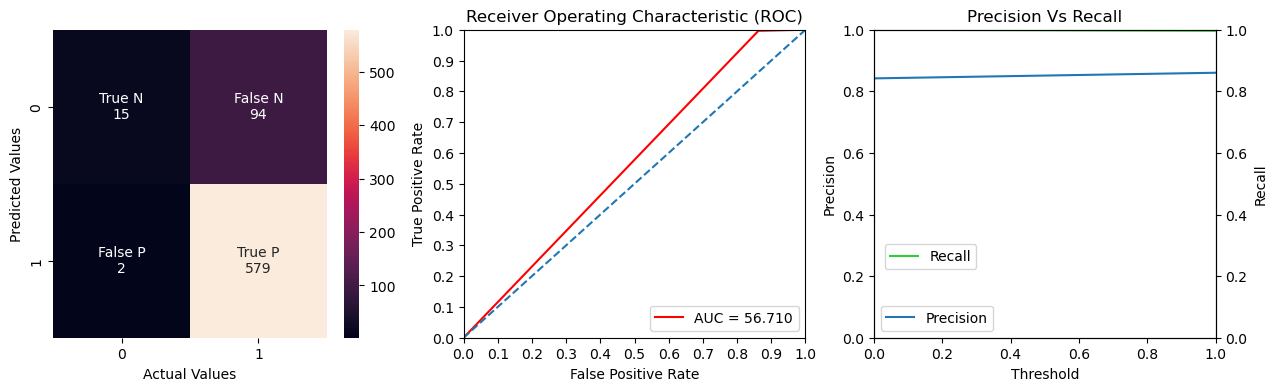

In [88]:
#Decision Tree PCA + Grid
df_cm, df_perf = model_perf(tree_pruned, Y_test, predictions_DT_G, "DTGrid PCA", df_cm, df_perf, plot = True)

## Bagging

In [89]:

# train_test_split
#X_train, X_test, Y_train, Y_test = split_df(PCA_Data, seed=rand_seed, percentage=0.7)
#print("Number of explanatories: ", len(Data.columns)-1)

bagging = RandomForestClassifier(n_estimators=200, oob_score=True) # no max_features option=Bagging
bagging.fit(X_train, Y_train)
predictions_bagg = bagging.predict(X_test)
accBagg=bagging.oob_score_
print("Accuracy OOB set - Bagging = {0:.2%}".format(accBagg))

f1_Bagg = f1_score(Y_test,predictions_bagg, average='weighted')
precision_Bagg = precision_score(Y_test, predictions_bagg, average='weighted')
recall_Bagg = recall_score(Y_test, predictions_bagg, average='weighted')

class_report_Bagging = classification_report(Y_test, predictions_bagg)
#print(class_report_Bagging)

Accuracy OOB set - Bagging = 86.19%


Accuracy of Bagg PCA for Test data is 86.66666666666667

F1-score of Bagg PCA for Test data is 92.5925925925926

Classification report for Bagg PCA is: 
               precision    recall  f1-score   support

         0.0       0.79      0.21      0.33       109
         1.0       0.87      0.99      0.93       581

    accuracy                           0.87       690
   macro avg       0.83      0.60      0.63       690
weighted avg       0.86      0.87      0.83       690

AUC for Bagg PCA: 60.03



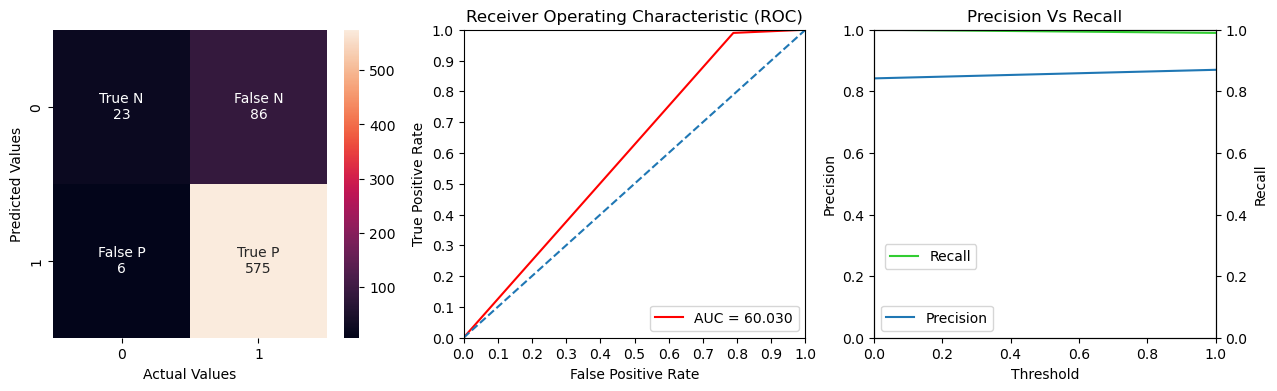

In [90]:
#Bagg + PCA
df_cm, df_perf = model_perf(bagging, Y_test, predictions_bagg, "Bagg PCA", df_cm, df_perf, plot = True)

In [91]:

#with GRID SEARCH

# train_test_split
#X_train, X_test, Y_train, Y_test = split_df(PCA_Data, seed=rand_seed, percentage=0.7)
#print("Number of explanatories: ", len(Data.columns)-1)

param_grid = {'min_samples_leaf' :[3,4,5,6,7]}

BaggGrid = GridSearchCV(bagging, param_grid=param_grid, cv=5, scoring=acc, verbose=2) 
BaggGrid.fit(X_train,Y_train)
print("Best param: ", BaggGrid.best_params_)
model = RandomForestClassifier(n_estimators = 200, oob_score = True,
                               min_samples_leaf = BaggGrid.best_params_["min_samples_leaf"])
model.fit(X_train,Y_train)
predictions_bagg_G = model.predict(X_test)
accBaggGrid=model.oob_score_
print("Accuracy OOB set - Bagging with Grid Searching: {0:.2%}".format(accBaggGrid))

f1_BaggGrid = f1_score(Y_test,predictions_bagg_G, average='weighted')
precision_BaggGrid = precision_score(Y_test, predictions_bagg_G, average='weighted')
recall_BaggGrid = recall_score(Y_test, predictions_bagg_G, average='weighted')

class_report_Bagging_Grid = classification_report(Y_test, predictions_bagg_G)
print(class_report_Bagging_Grid)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .................................min_samples_leaf=3; total time=   0.5s
[CV] END .................................min_samples_leaf=3; total time=   0.5s
[CV] END .................................min_samples_leaf=3; total time=   0.5s
[CV] END .................................min_samples_leaf=3; total time=   0.5s
[CV] END .................................min_samples_leaf=3; total time=   0.5s
[CV] END .................................min_samples_leaf=4; total time=   0.5s
[CV] END .................................min_samples_leaf=4; total time=   0.5s
[CV] END .................................min_samples_leaf=4; total time=   0.5s
[CV] END .................................min_samples_leaf=4; total time=   0.5s
[CV] END .................................min_samples_leaf=4; total time=   0.5s
[CV] END .................................min_samples_leaf=5; total time=   0.5s
[CV] END .................................min_sam

Accuracy of BaggGrid PCA for Test data is 86.81159420289855

F1-score of BaggGrid PCA for Test data is 92.69076305220884

Classification report for BaggGrid PCA is: 
               precision    recall  f1-score   support

         0.0       0.85      0.20      0.33       109
         1.0       0.87      0.99      0.93       581

    accuracy                           0.87       690
   macro avg       0.86      0.60      0.63       690
weighted avg       0.87      0.87      0.83       690

AUC for BaggGrid PCA: 59.75



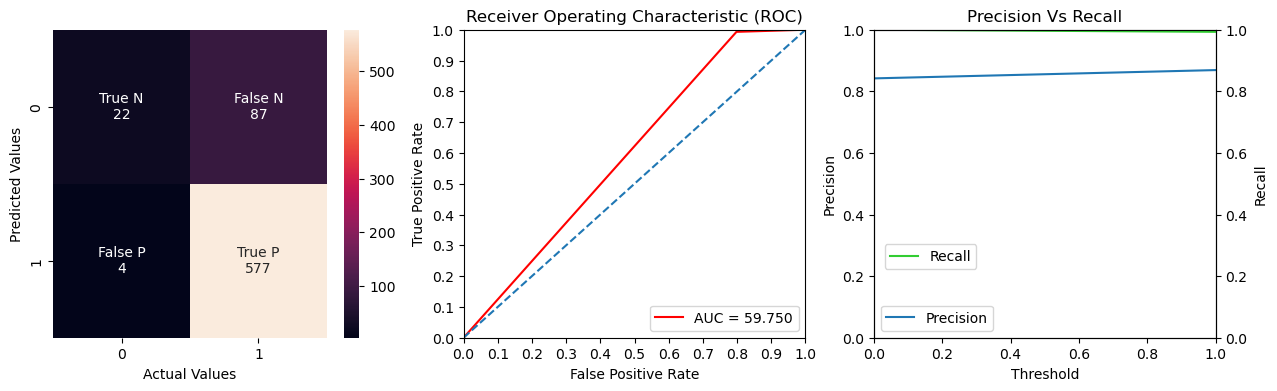

In [92]:
#Bagg + PCA + Grid
df_cm, df_perf = model_perf(BaggGrid, Y_test, predictions_bagg_G, "BaggGrid PCA", df_cm, df_perf, plot = True)

## Random Forest

In [93]:

# train_test_split
#X_train, X_test, Y_train, Y_test = split_df(PCA_Data, seed=rand_seed, percentage=0.7)
#print("Number of explanatories: ", len(Data.columns)-1)

RandomForest = RandomForestClassifier(n_estimators=200, oob_score=True, max_features=8) # 62 explanatories
RandomForest.fit(X_train, Y_train)
accRF=RandomForest.oob_score_
print("Accuracy OOB set Random Forests = {0:.2%}".format(accRF))

predictions_RF = RandomForest.predict(X_test)

f1_RF = f1_score(Y_test,predictions_RF, average='weighted')
precision_RF = precision_score(Y_test, predictions_RF, average='weighted')
recall_RF = recall_score(Y_test, predictions_RF, average='weighted')

class_report_RandomForest = classification_report(Y_test, predictions_RF)
#print(class_report_Bagging_Grid)

Accuracy OOB set Random Forests = 86.57%


Accuracy of RF PCA for Test data is 86.23188405797102

F1-score of RF PCA for Test data is 92.34488315874295

Classification report for RF PCA is: 
               precision    recall  f1-score   support

         0.0       0.73      0.20      0.32       109
         1.0       0.87      0.99      0.92       581

    accuracy                           0.86       690
   macro avg       0.80      0.59      0.62       690
weighted avg       0.85      0.86      0.83       690

AUC for RF PCA: 59.4



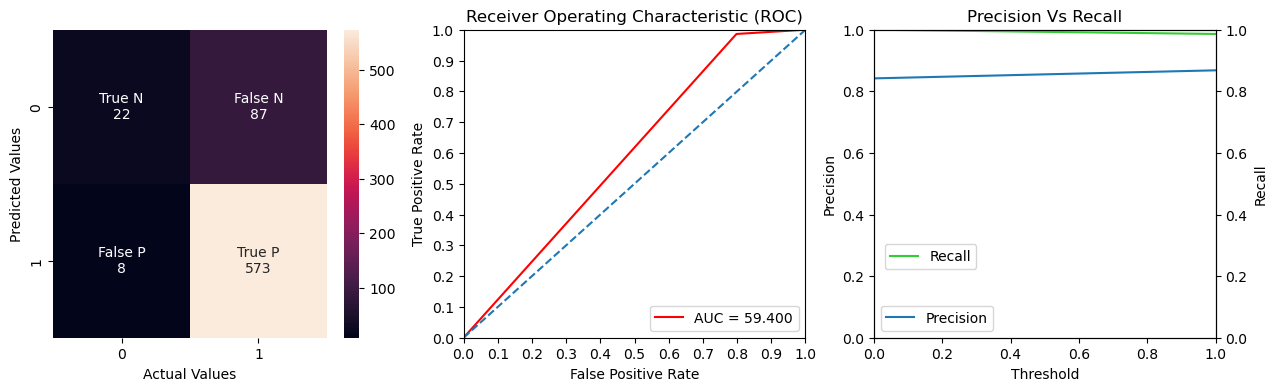

In [94]:
#RF + PCA
df_cm, df_perf = model_perf(RandomForest, Y_test, predictions_RF, "RF PCA", df_cm, df_perf, plot = True)

In [95]:

#with Grid search
# train_test_split
#X_train, X_test, Y_train, Y_test = split_df(PCA_Data, seed=rand_seed, percentage=0.7)
#print("Number of explanatories: ", len(Data.columns)-1)

param_grid = {
    'min_samples_leaf' :[3,4,5,6], 
    'max_features' : [10,15,20,25,30],
}

RFGrid = GridSearchCV(RandomForest, param_grid=param_grid, cv=5, scoring=acc, verbose=2) 
RFGrid.fit(X_train,Y_train)
print("Best param: ", RFGrid.best_params_)
model = RandomForestClassifier(n_estimators=200, oob_score=True, 
                               max_features=RFGrid.best_params_["max_features"], 
                               min_samples_leaf=RFGrid.best_params_["min_samples_leaf"])
model.fit(X_train,Y_train)
accRFGrid=model.oob_score_
print("Accuracy OOB set - RF with Grid Searching: {0:.2%}".format(accRFGrid))

predictions_RF_G = model.predict(X_test)


f1_RFGrid = f1_score(Y_test,predictions_RF_G, average='weighted')
precision_RFGrid = precision_score(Y_test, predictions_RF_G, average='weighted')
recall_RFGrid = recall_score(Y_test, predictions_RF_G, average='weighted')

class_report_RandomForest_Grid = classification_report(Y_test, predictions_RF_G)
print(class_report_RandomForest_Grid)



Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ................max_features=10, min_samples_leaf=3; total time=   0.6s
[CV] END ................max_features=10, min_samples_leaf=3; total time=   0.6s
[CV] END ................max_features=10, min_samples_leaf=3; total time=   0.6s
[CV] END ................max_features=10, min_samples_leaf=3; total time=   0.6s
[CV] END ................max_features=10, min_samples_leaf=3; total time=   0.6s
[CV] END ................max_features=10, min_samples_leaf=4; total time=   0.6s
[CV] END ................max_features=10, min_samples_leaf=4; total time=   0.6s
[CV] END ................max_features=10, min_samples_leaf=4; total time=   0.6s
[CV] END ................max_features=10, min_samples_leaf=4; total time=   0.6s
[CV] END ................max_features=10, min_samples_leaf=4; total time=   0.6s
[CV] END ................max_features=10, min_samples_leaf=5; total time=   0.5s
[CV] END ................max_features=10, min_s

Accuracy of RFGrid PCA for Test data is 87.10144927536231

F1-score of RFGrid PCA for Test data is 92.82836422240129

Classification report for RFGrid PCA is: 
               precision    recall  f1-score   support

         0.0       0.83      0.23      0.36       109
         1.0       0.87      0.99      0.93       581

    accuracy                           0.87       690
   macro avg       0.85      0.61      0.64       690
weighted avg       0.87      0.87      0.84       690

AUC for RFGrid PCA: 61.04



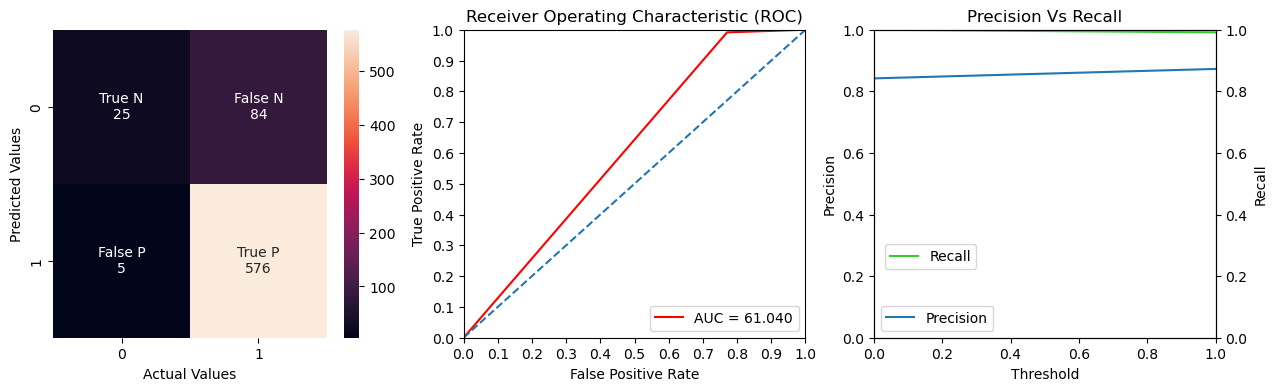

In [96]:
#RF + PCA + Grid
df_cm, df_perf = model_perf(RFGrid, Y_test, predictions_RF_G, "RFGrid PCA", df_cm, df_perf, plot = True)

## Boosting


In [97]:

# train_test_split
#X_train, X_test, Y_train, Y_test = split_df(PCA_Data, seed=rand_seed, percentage=0.7)
#print("Number of explanatories: ", len(Data.columns)-1)

xgb = XGBClassifier(n_estimators=200)

xgb.fit(X_train, Y_train)
predictions_XGBC = xgb.predict(X_test)
accBoost = accuracy_score(predictions_XGBC, Y_test)
print("Accuracy test set of XGBClassifier: {0:.2%}".format(accBoost))


f1_Boost = f1_score(Y_test,predictions_XGBC, average='weighted')
precision_Boost = precision_score(Y_test, predictions_XGBC, average='weighted')
recall_Boost = recall_score(Y_test, predictions_XGBC, average='weighted')

class_report_XGBOOST = classification_report(Y_test, predictions_XGBC)
#print(class_report_XGBOOST)

Accuracy test set of XGBClassifier: 86.09%


Accuracy of XGB PCA for Test data is 86.08695652173914

F1-score of XGB PCA for Test data is 92.10526315789474

Classification report for XGB PCA is: 
               precision    recall  f1-score   support

         0.0       0.62      0.31      0.41       109
         1.0       0.88      0.96      0.92       581

    accuracy                           0.86       690
   macro avg       0.75      0.64      0.67       690
weighted avg       0.84      0.86      0.84       690

AUC for XGB PCA: 63.79



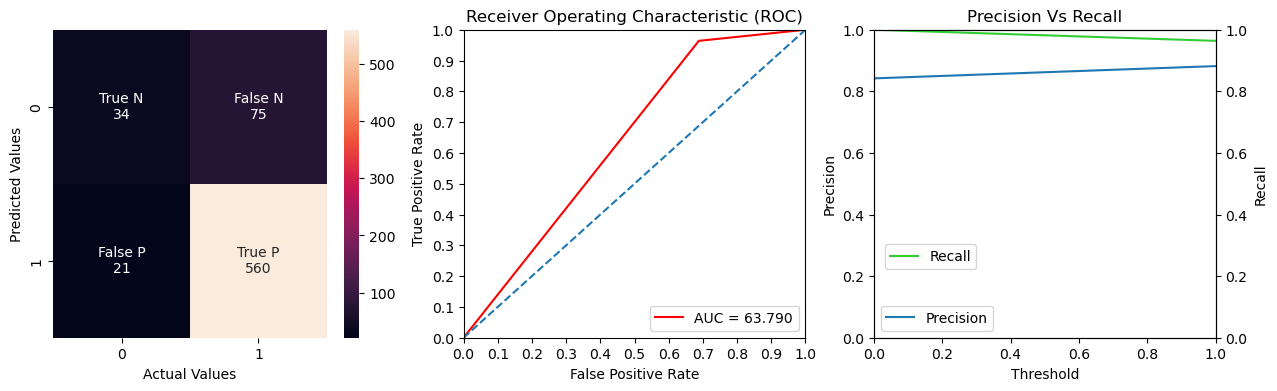

In [98]:
#XGB + PCA
df_cm, df_perf = model_perf(xgb, Y_test, predictions_XGBC, "XGB PCA", df_cm, df_perf, plot = True)

In [99]:

# With GRID SEARCH
X_train, X_test, Y_train, Y_test = split_df(PCA_Data, seed=rand_seed, percentage=0.7)
print("Number of explanatories: ", len(Data.columns)-1)

params = {
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 7], 
        'learning_rate': [0.001, 0.01, 0.1],
        }

xgbGrid = GridSearchCV(xgb, params, cv = 5, scoring=acc, verbose=2)
xgbGrid.fit(X_train, Y_train)
print("Best set of hyperparameters: ", xgbGrid.best_params_)

xgb_model_Grid = XGBClassifier(n_estimators=200, learning_rate=xgbGrid.best_params_["learning_rate"],
                    max_depth=xgbGrid.best_params_["max_depth"],
                    subsample=xgbGrid.best_params_["subsample"])

xgb_model_Grid.fit(X_train, Y_train)
predictions_XGBC_G = xgb_model_Grid.predict(X_test)
accBoostGrid=accuracy_score(Y_test, predictions_XGBC_G)
print("Accuracy test set - Boosting with Grid Searching: {0:.2%}".format(accBoostGrid))

f1_BoostGrid = f1_score(Y_test,predictions_XGBC_G, average='weighted')
precision_BoostGrid = precision_score(Y_test, predictions_XGBC_G, average='weighted')
recall_BoostGrid = recall_score(Y_test, predictions_XGBC_G, average='weighted')

class_report_XGBOOST_Grid = classification_report(Y_test, predictions_XGBC_G)
print(class_report_XGBOOST_Grid)




Number of explanatories:  54
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ....learning_rate=0.001, max_depth=3, subsample=0.6; total time=   0.1s
[CV] END ....learning_rate=0.001, max_depth=3, subsample=0.6; total time=   0.2s
[CV] END ....learning_rate=0.001, max_depth=3, subsample=0.6; total time=   0.1s
[CV] END ....learning_rate=0.001, max_depth=3, subsample=0.6; total time=   0.1s
[CV] END ....learning_rate=0.001, max_depth=3, subsample=0.6; total time=   0.2s
[CV] END ....learning_rate=0.001, max_depth=3, subsample=0.8; total time=   0.1s
[CV] END ....learning_rate=0.001, max_depth=3, subsample=0.8; total time=   0.1s
[CV] END ....learning_rate=0.001, max_depth=3, subsample=0.8; total time=   0.2s
[CV] END ....learning_rate=0.001, max_depth=3, subsample=0.8; total time=   0.1s
[CV] END ....learning_rate=0.001, max_depth=3, subsample=0.8; total time=   0.1s
[CV] END ....learning_rate=0.001, max_depth=3, subsample=1.0; total time=   0.2s
[CV] END ....learn

Accuracy of XGBGrid PCA for Test data is 87.68115942028986

F1-score of XGBGrid PCA for Test data is 93.16170555108609

Classification report for XGBGrid PCA is: 
               precision    recall  f1-score   support

         0.0       0.93      0.24      0.38       109
         1.0       0.87      1.00      0.93       581

    accuracy                           0.88       690
   macro avg       0.90      0.62      0.66       690
weighted avg       0.88      0.88      0.84       690

AUC for XGBGrid PCA: 61.75



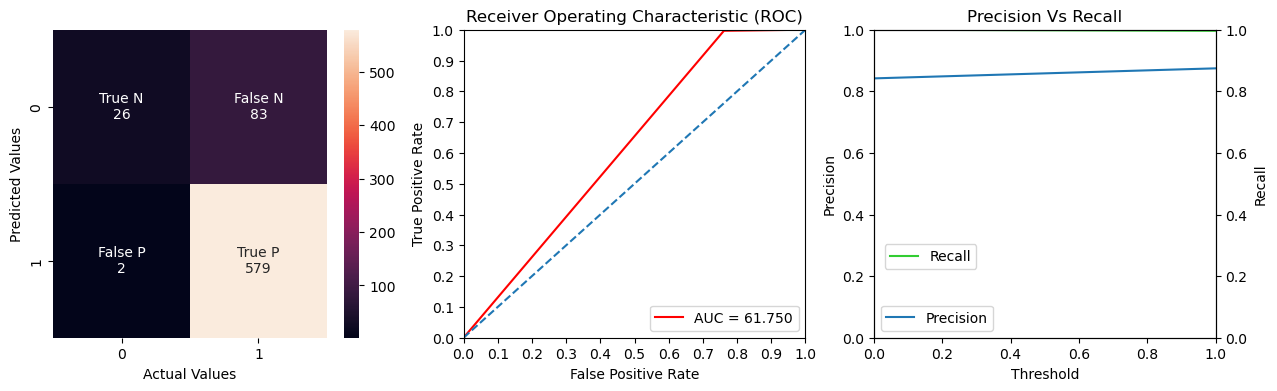

In [100]:
#XGB + PCA + Gridd
df_cm, df_perf = model_perf(xgb_model_Grid, Y_test, predictions_XGBC_G, "XGBGrid PCA", df_cm, df_perf, plot = True)

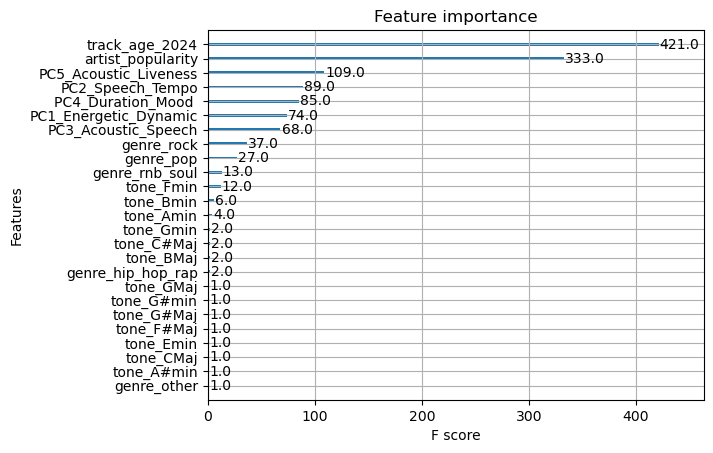

In [101]:
import xgboost as xgb


xgb.plot_importance(xgb_model_Grid, importance_type='weight')
plt.show()


## KNN


In [102]:
# Second Standardize
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
#Data = w/O PCA
#PCA_Data = PCA
#min_max_scaler = MinMaxScaler()
#data = min_max_scaler.fit_transform(data)
# Initialize the StandardScaler
standard_scaler = StandardScaler()

# Fit on the training data
standard_scaler.fit(X_train)

# Transform both the training and the test data with the fitted scaler
X_train_sc = standard_scaler.transform(X_train)
X_test_sc = standard_scaler.transform(X_test)




In [103]:
#Model 1


knn_classifier = KNeighborsClassifier(n_neighbors=5)

knn_classifier.fit(X_train, Y_train)

# Predictions (on test set, obviously)
knn_predictions = knn_classifier.predict(X_test)

# Calculate error_rate
acc_KNN_M1 = accuracy_score(Y_test, knn_predictions)
error_rate = 1 - accuracy_score(Y_test, knn_predictions)
print("Error (k=5): {0:.2%}".format(error_rate))

f1_KNN_M1 = f1_score(Y_test,knn_predictions, average='weighted')
precision_KNN_M1 = precision_score(Y_test, knn_predictions, average='weighted')
recall_KNN_M1 = recall_score(Y_test, knn_predictions, average='weighted')

class_report_KNN_m1 = classification_report(Y_test, knn_predictions)
#print(class_report_KNN_m1)

Error (k=5): 15.07%


Accuracy of KNN M1 PCA for Test data is 84.92753623188406

F1-score of KNN M1 PCA for Test data is 91.41914191419141

Classification report for KNN M1 PCA is: 
               precision    recall  f1-score   support

         0.0       0.54      0.29      0.38       109
         1.0       0.88      0.95      0.91       581

    accuracy                           0.85       690
   macro avg       0.71      0.62      0.65       690
weighted avg       0.82      0.85      0.83       690

AUC for KNN M1 PCA: 62.36



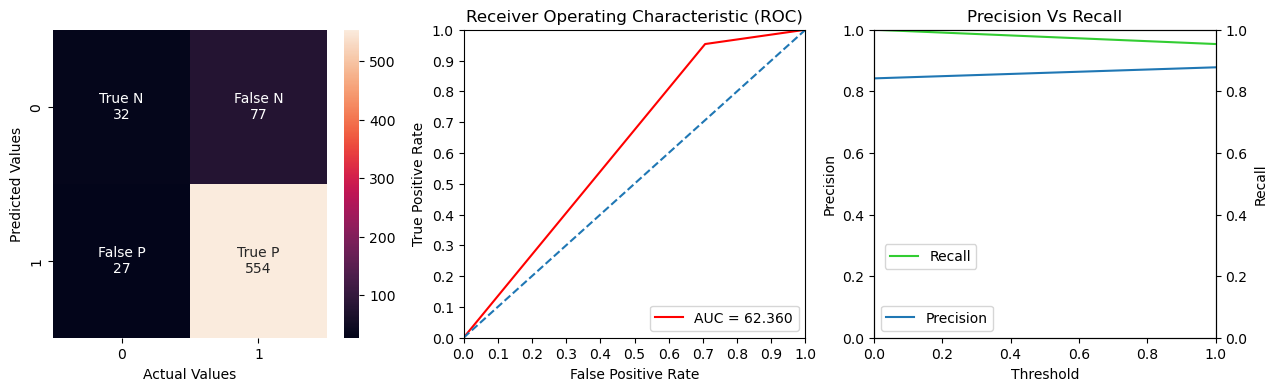

In [104]:
#KNN + PCA
df_cm, df_perf = model_perf(knn_classifier, Y_test, knn_predictions, "KNN M1 PCA", df_cm, df_perf, plot = True)

In [105]:
#Model 2 w/ grid Search

parameters = {
    "n_neighbors": range(1, 50),
    "weights": ["uniform", "distance"]
}
knn_Grid_M2 = GridSearchCV(KNeighborsClassifier(), parameters, cv=5, verbose=2)
knn_Grid_M2 .fit(X_train, Y_train)
print("Best parameters: ", knn_Grid_M2 .best_params_)

train_preds_grid = knn_Grid_M2 .predict(X_train)
predictions = knn_Grid_M2 .predict(X_test)

Fitting 5 folds for each of 98 candidates, totalling 490 fits
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END .....................n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=2, we

In [106]:
knn_classifier_M2 = KNeighborsClassifier(n_neighbors=knn_Grid_M2.best_params_['n_neighbors'],weights=knn_Grid_M2.best_params_['weights'])

knn_classifier_M2.fit(X_train, Y_train)

# Predictions (on test set, obviously)
knn_predictions_M2 = knn_classifier_M2.predict(X_test)

# Calculate error_rate
acc_KNN_M2 = accuracy_score(Y_test, knn_predictions_M2)
error_rate_M2 = 1 - accuracy_score(Y_test, knn_predictions_M2)
print("Error (k=5): {0:.2%}".format(error_rate_M2))

f1_KNN_M2 = f1_score(Y_test,knn_predictions_M2, average='weighted')
precision_KNN_M2 = precision_score(Y_test, knn_predictions_M2, average='weighted')
recall_KNN_M2 = recall_score(Y_test, knn_predictions_M2, average='weighted')

class_report_KNN_M2 = classification_report(Y_test, knn_predictions_M2)
print(class_report_KNN_M2)

Error (k=5): 12.46%
              precision    recall  f1-score   support

         0.0       0.81      0.28      0.41       109
         1.0       0.88      0.99      0.93       581

    accuracy                           0.88       690
   macro avg       0.84      0.63      0.67       690
weighted avg       0.87      0.88      0.85       690



Accuracy of KNN M2 Grid PCA for Test data is 87.53623188405797

F1-score of KNN M2 Grid PCA for Test data is 93.03079416531604

Classification report for KNN M2 Grid PCA is: 
               precision    recall  f1-score   support

         0.0       0.81      0.28      0.41       109
         1.0       0.88      0.99      0.93       581

    accuracy                           0.88       690
   macro avg       0.84      0.63      0.67       690
weighted avg       0.87      0.88      0.85       690

AUC for KNN M2 Grid PCA: 63.16



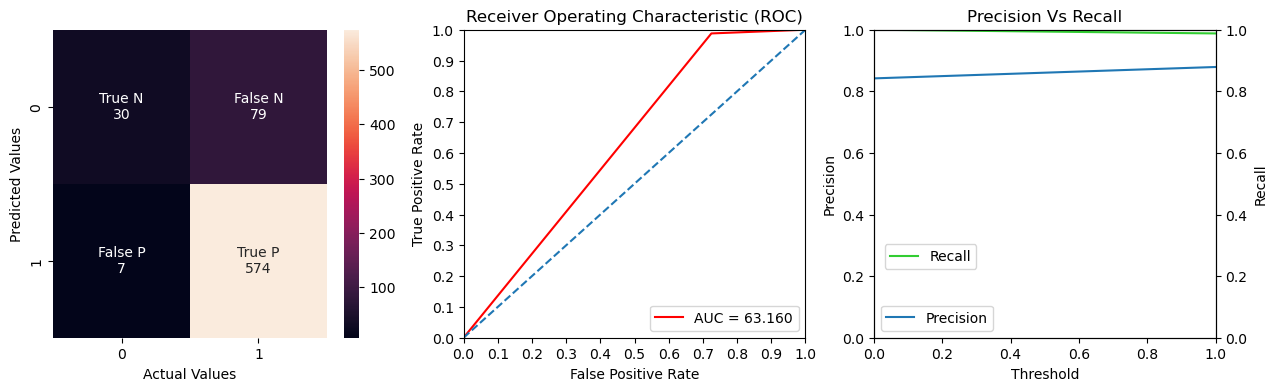

In [107]:
#KNN + PCA + Gridd
df_cm, df_perf = model_perf(knn_classifier_M2, Y_test, knn_predictions_M2, "KNN M2 Grid PCA", df_cm, df_perf, plot = True)

# EVALUATION THE MODELS


In [108]:
class_report_variables = [var for var in globals() if var.startswith("class_report")]
print(class_report_variables)


['class_report', 'class_report_PCA_Logit', 'class_report_Decision_Tree', 'class_report_Decision_Tree_Grid', 'class_report_Bagging', 'class_report_Bagging_Grid', 'class_report_RandomForest', 'class_report_RandomForest_Grid', 'class_report_XGBOOST', 'class_report_XGBOOST_Grid', 'class_report_KNN_m1', 'class_report_KNN_M2', 'class_report_variables']


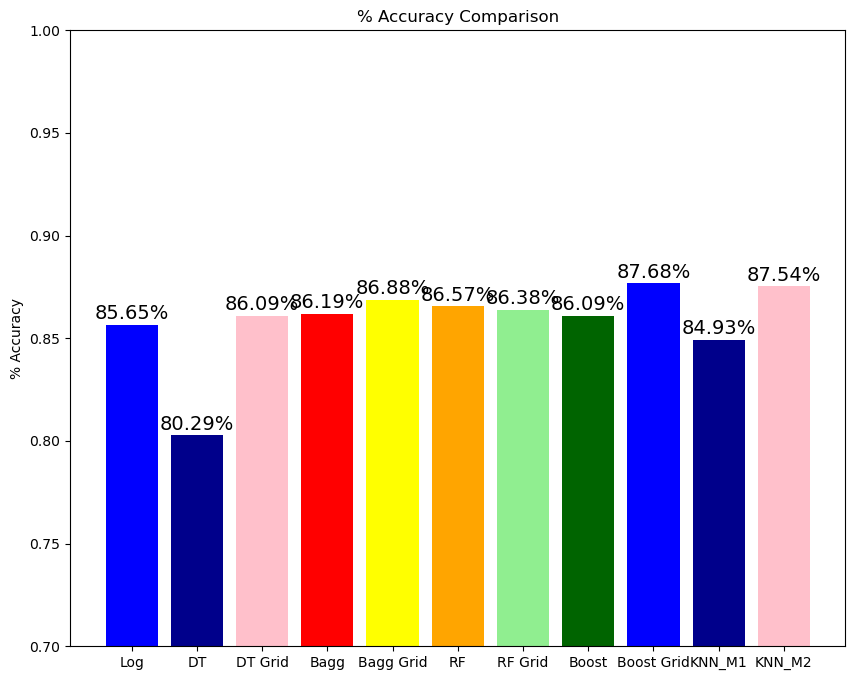

In [109]:
categ = ['Log','DT', 'DT Grid', 'Bagg', 'Bagg Grid', 'RF', 'RF Grid', 'Boost', 'Boost Grid', 'KNN_M1', 'KNN_M2']
values = [acclog,accDT, accDTGrid, accBagg, accBaggGrid, accRF, accRFGrid, accBoost, accBoostGrid,acc_KNN_M1, acc_KNN_M2]
colors = ['blue', 'darkblue', 'pink', 'red', 'yellow', 'orange', 'lightgreen', 'darkgreen'] 

plt.figure(figsize=(10,8))
plt.bar(categ, values, color=colors)
plt.ylim(.70, 1)

plt.xlabel('')
plt.ylabel('% Accuracy')
plt.title('% Accuracy Comparison')

for i, v in enumerate(values):
    plt.text(i, v+0.01, "{0:.2%}".format(v) , ha='center', va='top', fontsize=14)
    
plt.show()

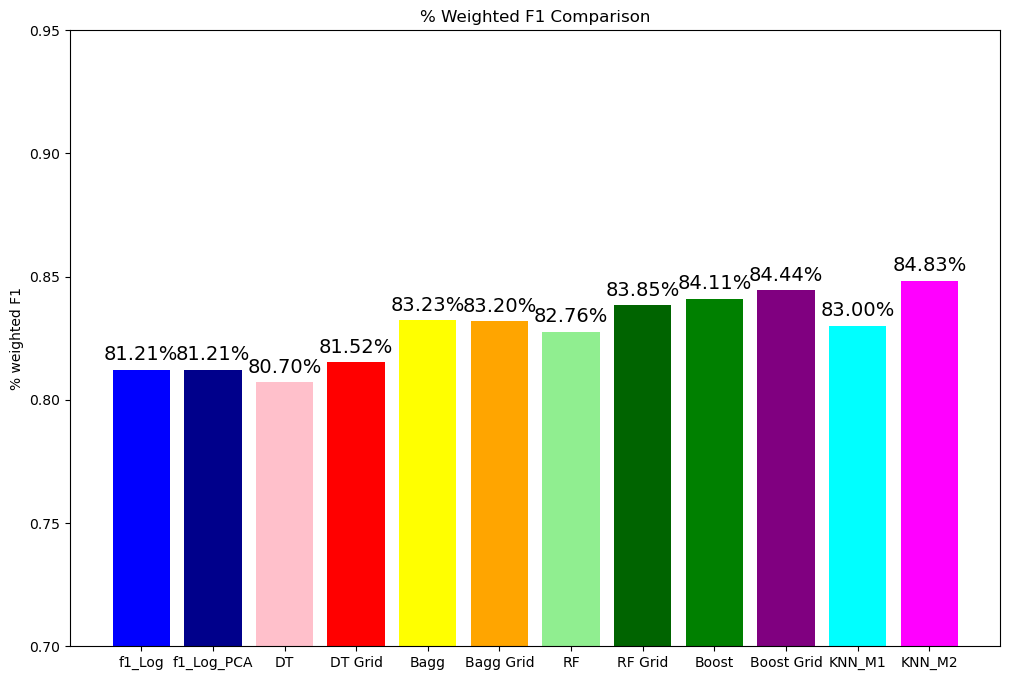

In [110]:
categ = ['f1_Log','f1_Log_PCA','DT', 'DT Grid', 'Bagg', 'Bagg Grid', 'RF', 'RF Grid', 'Boost', 'Boost Grid','KNN_M1','KNN_M2']
values = [f1_Log,f1_Log_PCA,f1_Tree,f1_TreeGrid, f1_Bagg, f1_BaggGrid, f1_RF, f1_RFGrid, f1_Boost, f1_BoostGrid, f1_KNN_M1, f1_KNN_M2]
colors = ['blue', 'darkblue', 'pink', 'red', 'yellow', 'orange', 'lightgreen', 'darkgreen', 'green','purple','cyan', 'magenta'] 

plt.figure(figsize=(12,8))
plt.bar(categ, values, color=colors)
plt.ylim(.70, .95)

plt.xlabel('')
plt.ylabel('% weighted F1')
plt.title('% Weighted F1 Comparison')

for i, v in enumerate(values):
    plt.text(i, v+0.01, "{0:.2%}".format(v) , ha='center', va='top', fontsize=14)
    
plt.show()

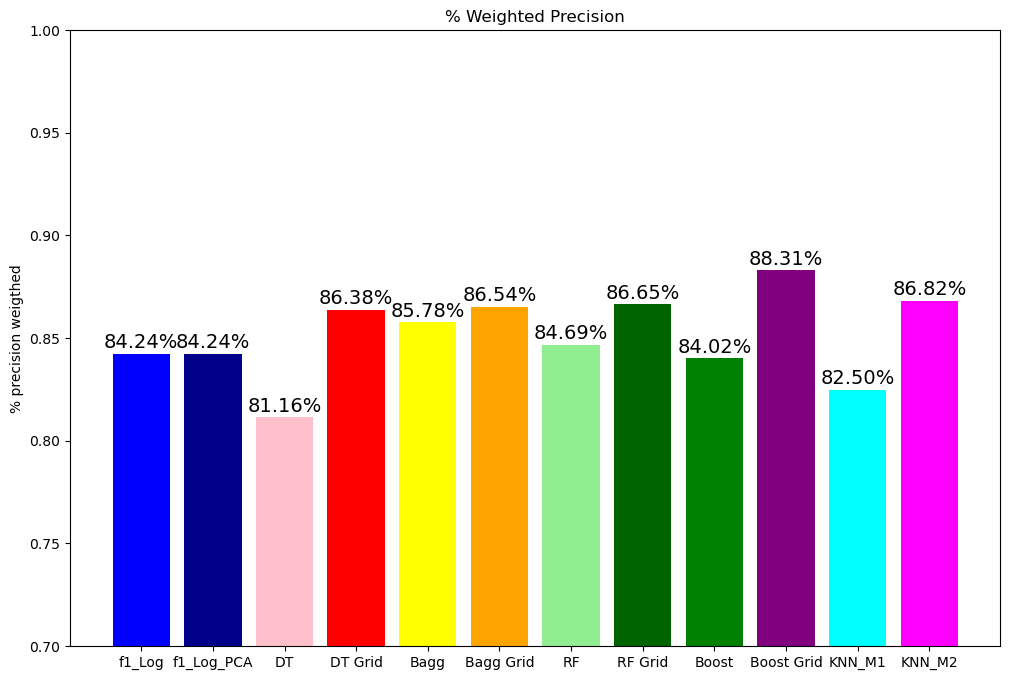

In [111]:
categ = ['f1_Log','f1_Log_PCA','DT', 'DT Grid', 'Bagg', 'Bagg Grid', 'RF', 'RF Grid', 'Boost', 'Boost Grid','KNN_M1', 'KNN_M2']
values = [precision_Log,precision_Log_PCA,precision_Tree,precision_TreeGrid, precision_Bagg, precision_BaggGrid, precision_RF, precision_RFGrid, precision_Boost, precision_BoostGrid, precision_KNN_M1, precision_KNN_M2]
colors = ['blue', 'darkblue', 'pink', 'red', 'yellow', 'orange', 'lightgreen', 'darkgreen', 'green','purple','cyan', 'magenta'] 

plt.figure(figsize=(12,8))
plt.bar(categ, values, color=colors)
plt.ylim(.70, 1)

plt.xlabel('')
plt.ylabel('% precision weigthed')
plt.title('% Weighted Precision')

for i, v in enumerate(values):
    plt.text(i, v+0.01, "{0:.2%}".format(v) , ha='center', va='top', fontsize=14)
    
plt.show()

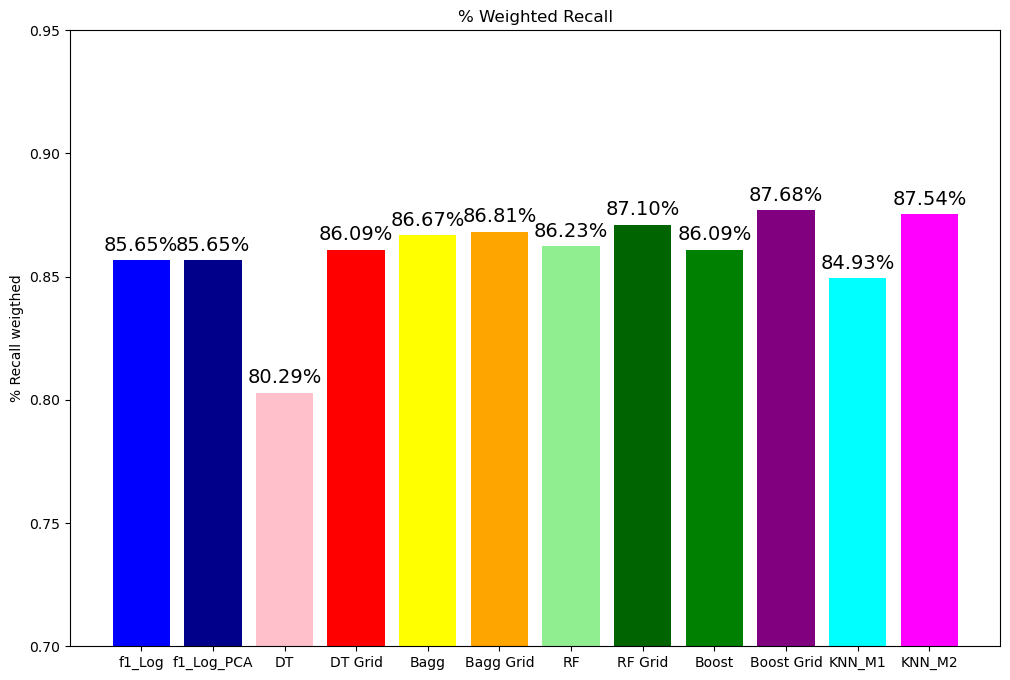

In [112]:
categ = ['f1_Log','f1_Log_PCA','DT', 'DT Grid', 'Bagg', 'Bagg Grid', 'RF', 'RF Grid', 'Boost', 'Boost Grid','KNN_M1', 'KNN_M2']
values = [recall_Log,recall_Log_PCA,recall_Tree,recall_TreeGrid, recall_Bagg, recall_BaggGrid, recall_RF, recall_RFGrid, recall_Boost, recall_BoostGrid, recall_KNN_M1, recall_KNN_M2]
colors = ['blue', 'darkblue', 'pink', 'red', 'yellow', 'orange', 'lightgreen', 'darkgreen', 'green','purple','cyan', 'magenta'] 

plt.figure(figsize=(12,8))
plt.bar(categ, values, color=colors)
plt.ylim(.70, .95)

plt.xlabel('')
plt.ylabel('% Recall weigthed')
plt.title('% Weighted Recall')

for i, v in enumerate(values):
    plt.text(i, v+0.01, "{0:.2%}".format(v) , ha='center', va='top', fontsize=14)
    
plt.show()

Exporting Model


In [1]:
from joblib import dump

# Assume `xgb_model_Grid` is your trained model variable
dump(xgb_model_Grid, '/Users/lucazosso/Desktop/IE_Course/Term_2/Machine Learning II/Group Assignement/MLOps/xgb_model_Grid.joblib')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


NameError: name 'xgb_model_Grid' is not defined